<a href="https://colab.research.google.com/github/chamithZ/DL_LAB_3/blob/main/DL_Lab_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lab 3

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, MaxPooling2D, AveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
import numpy as np
import os
import cv2
import h5py
import matplotlib.pyplot as plt
from numpy import genfromtxt

_FLOATX = 'float32'

def variable(value, dtype=_FLOATX, name=None):
    v = tf.Variable(np.asarray(value, dtype=dtype), name=name)
    return v

def shape(x):
    return x.shape

def square(x):
    return tf.square(x)

def zeros(shape, dtype=_FLOATX, name=None):
    return variable(np.zeros(shape), dtype, name)

def concatenate(tensors, axis=-1):
    if axis < 0:
        axis = axis % len(tensors[0].shape)
    return tf.concat(tensors, axis=axis)

def LRN2D(x):
    return tf.nn.lrn(x, alpha=1e-4, beta=0.75)

def conv2d_bn(x,
              layer=None,
              cv1_out=None,
              cv1_filter=(1, 1),
              cv1_strides=(1, 1),
              cv2_out=None,
              cv2_filter=(3, 3),
              cv2_strides=(1, 1),
              padding=None):
    num = '' if cv2_out is None else '1'
    tensor = Conv2D(cv1_out, cv1_filter, strides=cv1_strides, data_format='channels_first', name=layer+'_conv'+num)(x)
    tensor = BatchNormalization(axis=1, epsilon=0.00001, name=layer+'_bn'+num)(tensor)
    tensor = Activation('relu')(tensor)
    if padding is None:
        return tensor
    tensor = ZeroPadding2D(padding=padding, data_format='channels_first')(tensor)
    if cv2_out is None:
        return tensor
    tensor = Conv2D(cv2_out, cv2_filter, strides=cv2_strides, data_format='channels_first', name=layer+'_conv'+'2')(tensor)
    tensor = BatchNormalization(axis=1, epsilon=0.00001, name=layer+'_bn'+'2')(tensor)
    tensor = Activation('relu')(tensor)
    return tensor

WEIGHTS = [
  'conv1', 'bn1', 'conv2', 'bn2', 'conv3', 'bn3',
  'inception_3a_1x1_conv', 'inception_3a_1x1_bn',
  'inception_3a_pool_conv', 'inception_3a_pool_bn',
  'inception_3a_5x5_conv1', 'inception_3a_5x5_conv2', 'inception_3a_5x5_bn1', 'inception_3a_5x5_bn2',
  'inception_3a_3x3_conv1', 'inception_3a_3x3_conv2', 'inception_3a_3x3_bn1', 'inception_3a_3x3_bn2',
  'inception_3b_3x3_conv1', 'inception_3b_3x3_conv2', 'inception_3b_3x3_bn1', 'inception_3b_3x3_bn2',
  'inception_3b_5x5_conv1', 'inception_3b_5x5_conv2', 'inception_3b_5x5_bn1', 'inception_3b_5x5_bn2',
  'inception_3b_pool_conv', 'inception_3b_pool_bn',
  'inception_3b_1x1_conv', 'inception_3b_1x1_bn',
  'inception_3c_3x3_conv1', 'inception_3c_3x3_conv2', 'inception_3c_3x3_bn1', 'inception_3c_3x3_bn2',
  'inception_3c_5x5_conv1', 'inception_3c_5x5_conv2', 'inception_3c_5x5_bn1', 'inception_3c_5x5_bn2',
  'inception_4a_3x3_conv1', 'inception_4a_3x3_conv2', 'inception_4a_3x3_bn1', 'inception_4a_3x3_bn2',
  'inception_4a_5x5_conv1', 'inception_4a_5x5_conv2', 'inception_4a_5x5_bn1', 'inception_4a_5x5_bn2',
  'inception_4a_pool_conv', 'inception_4a_pool_bn',
  'inception_4a_1x1_conv', 'inception_4a_1x1_bn',
  'inception_4e_3x3_conv1', 'inception_4e_3x3_conv2', 'inception_4e_3x3_bn1', 'inception_4e_3x3_bn2',
  'inception_4e_5x5_conv1', 'inception_4e_5x5_conv2', 'inception_4e_5x5_bn1', 'inception_4e_5x5_bn2',
  'inception_5a_3x3_conv1', 'inception_5a_3x3_conv2', 'inception_5a_3x3_bn1', 'inception_5a_3x3_bn2',
  'inception_5a_pool_conv', 'inception_5a_pool_bn',
  'inception_5a_1x1_conv', 'inception_5a_1x1_bn',
  'inception_5b_3x3_conv1', 'inception_5b_3x3_conv2', 'inception_5b_3x3_bn1', 'inception_5b_3x3_bn2',
  'inception_5b_pool_conv', 'inception_5b_pool_bn',
  'inception_5b_1x1_conv', 'inception_5b_1x1_bn',
  'dense_layer'
]

conv_shape = {
  'conv1': [64, 3, 7, 7],
  'conv2': [64, 64, 1, 1],
  'conv3': [192, 64, 3, 3],
  'inception_3a_1x1_conv': [64, 192, 1, 1],
  'inception_3a_pool_conv': [32, 192, 1, 1],
  'inception_3a_5x5_conv1': [16, 192, 1, 1],
  'inception_3a_5x5_conv2': [32, 16, 5, 5],
  'inception_3a_3x3_conv1': [96, 192, 1, 1],
  'inception_3a_3x3_conv2': [128, 96, 3, 3],
  'inception_3b_3x3_conv1': [96, 256, 1, 1],
  'inception_3b_3x3_conv2': [128, 96, 3, 3],
  'inception_3b_5x5_conv1': [32, 256, 1, 1],
  'inception_3b_5x5_conv2': [64, 32, 5, 5],
  'inception_3b_pool_conv': [64, 256, 1, 1],
  'inception_3b_1x1_conv': [64, 256, 1, 1],
  'inception_3c_3x3_conv1': [128, 320, 1, 1],
  'inception_3c_3x3_conv2': [256, 128, 3, 3],
  'inception_3c_5x5_conv1': [32, 320, 1, 1],
  'inception_3c_5x5_conv2': [64, 32, 5, 5],
  'inception_4a_3x3_conv1': [96, 640, 1, 1],
  'inception_4a_3x3_conv2': [192, 96, 3, 3],
  'inception_4a_5x5_conv1': [32, 640, 1, 1,],
  'inception_4a_5x5_conv2': [64, 32, 5, 5],
  'inception_4a_pool_conv': [128, 640, 1, 1],
  'inception_4a_1x1_conv': [256, 640, 1, 1],
  'inception_4e_3x3_conv1': [160, 640, 1, 1],
  'inception_4e_3x3_conv2': [256, 160, 3, 3],
  'inception_4e_5x5_conv1': [64, 640, 1, 1],
  'inception_4e_5x5_conv2': [128, 64, 5, 5],
  'inception_5a_3x3_conv1': [96, 1024, 1, 1],
  'inception_5a_3x3_conv2': [384, 96, 3, 3],
  'inception_5a_pool_conv': [96, 1024, 1, 1],
  'inception_5a_1x1_conv': [256, 1024, 1, 1],
  'inception_5b_3x3_conv1': [96, 736, 1, 1],
  'inception_5b_3x3_conv2': [384, 96, 3, 3],
  'inception_5b_pool_conv': [96, 736, 1, 1],
  'inception_5b_1x1_conv': [256, 736, 1, 1],
}

def load_weights_from_FaceNet(FRmodel):
    weights = WEIGHTS
    weights_dict = load_weights()

    for name in weights:
        if FRmodel.get_layer(name) is not None:
            FRmodel.get_layer(name).set_weights(weights_dict[name])

def load_weights():
    dirPath = './weights'
    fileNames = filter(lambda f: not f.startswith('.'), os.listdir(dirPath))
    paths = {}
    weights_dict = {}

    for n in fileNames:
        paths[n.replace('.csv', '')] = dirPath + '/' + n

    for name in WEIGHTS:
        if 'conv' in name:
            conv_w = genfromtxt(paths[name + '_w'], delimiter=',', dtype=None)
            conv_w = np.reshape(conv_w, conv_shape[name])
            conv_w = np.transpose(conv_w, (2, 3, 1, 0))
            conv_b = genfromtxt(paths[name + '_b'], delimiter=',', dtype=None)
            weights_dict[name] = [conv_w, conv_b]
        elif 'bn' in name:
            bn_w = genfromtxt(paths[name + '_w'], delimiter=',', dtype=None)
            bn_b = genfromtxt(paths[name + '_b'], delimiter=',', dtype=None)
            bn_m = genfromtxt(paths[name + '_m'], delimiter=',', dtype=None)
            bn_v = genfromtxt(paths[name + '_v'], delimiter=',', dtype=None)
            weights_dict[name] = [bn_w, bn_b, bn_m, bn_v]
        elif 'dense' in name:
            dense_w = genfromtxt(dirPath+'/dense_w.csv', delimiter=',', dtype=None)
            dense_w = np.reshape(dense_w, (128, 736))
            dense_w = np.transpose(dense_w, (1, 0))
            dense_b = genfromtxt(dirPath+'/dense_b.csv', delimiter=',', dtype=None)
            weights_dict[name] = [dense_w, dense_b]

    return weights_dict

def load_dataset():
    train_dataset = h5py.File('datasets/train_happy.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:])
    train_set_y_orig = np.array(train_dataset["train_set_y"][:])

    test_dataset = h5py.File('datasets/test_happy.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:])
    test_set_y_orig = np.array(test_dataset["test_set_y"][:])

    classes = np.array(test_dataset["list_classes"][:])

    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

def img_to_encoding(image_path, model):
    img1 = cv2.imread(image_path, 1)
    img = img1[...,::-1]
    img = np.around(np.transpose(img, (2,0,1))/255.0, decimals=12)
    x_train = np.array([img])
    embedding = model.predict_on_batch(x_train)
    return embedding


In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image

# Load the image
img_path = "/content/image/ckk.jpg"
img = image.load_img(img_path, target_size=(96, 96))  # Resize to the required input size for the model
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = img_array / 255.0  # Normalize the image


In [6]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(128, activation='sigmoid')  # Example output layer for embeddings
])

model.compile(optimizer='adam', loss='binary_crossentropy')

encoding = model.predict(img_array)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


In [8]:
# Step 1: Import necessary libraries
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(128, activation='sigmoid')  # Example output layer for embeddings
])

model.compile(optimizer='adam', loss='binary_crossentropy')

encoding = model.predict(img_array)

# Step 3: Load and preprocess the image
img_path = "/content/image/ckk.jpg"
img = image.load_img(img_path, target_size=(96, 96))  # Resize to the model's input size
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = img_array / 255.0  # Normalize the image

# Step 4: Generate encoding
encoding = model.predict(img_array)

# Print the encoding to verify
print(encoding)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
[[0.5440567  0.49767056 0.49137366 0.46665308 0.5204836  0.50148433
  0.52027893 0.48740885 0.4847514  0.4804804  0.49272484 0.49812442
  0.4972626  0.4968918  0.5125534  0.4701597  0.52826947 0.4279881
  0.49550653 0.5043384  0.4878174  0.51937723 0.50155866 0.4897777
  0.47341257 0.52613187 0.52500397 0.49792868 0.49793145 0.5158668
  0.5252304  0.52733374 0.52050924 0.5407243  0.50247186 0.4975889
  0.5324451  0.4650278  0.51395494 0.4728668  0.5111834  0.46644682
  0.5193292  0.48740533 0.4789654  0.50356114 0.50778663 0.48112828
  0.4881488  0.4806064  0.4763182  0.45953503 0.48278928 0.4900043
  0.5133963  0.513233   0.46928686 0.4906378  0.5080023  0.52683204
  0.4527804  0.51335514 0.479641   0.46033502 0.5417667  0.49691325
  0.4855955  0.53060174 0.5017649  0.48821324 0.4623643  0.4796174
  0.503646   0.45300272 0.49727997 0.51669294 0.51142573 0.48639756
  0.45317855 0.5326901  0.4874566  0.49582127 

In [10]:
# Step 1: Import necessary libraries
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Step 2: Define a simple model for generating embeddings
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(128, activation='sigmoid')  # Example output layer for embeddings
])

model.compile(optimizer='adam', loss='binary_crossentropy')

# Step 3: Load and preprocess the image
img_path = "/content/image/ckk.jpg"  # Replace with the actual image file path
img = image.load_img(img_path, target_size=(96, 96))  # Resize to the model's input size
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = img_array / 255.0  # Normalize the image

# Step 4: Generate encoding
encoding = model.predict(img_array)

# Print the encoding to verify
print(encoding)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
[[0.5033504  0.51502913 0.47818497 0.47083902 0.47176573 0.48636338
  0.48912936 0.4997819  0.50267375 0.48823148 0.48418504 0.46802527
  0.52495646 0.528737   0.5172408  0.50261724 0.51221544 0.5368946
  0.5166653  0.5013484  0.51739115 0.4498096  0.45974135 0.5408978
  0.5103315  0.50898933 0.5028465  0.4904428  0.48032254 0.48655346
  0.47228494 0.5205109  0.5347     0.4990675  0.48351124 0.52876395
  0.5218056  0.5143046  0.5165806  0.4901163  0.47906703 0.5003005
  0.5100111  0.5135793  0.44990048 0.500842   0.47662932 0.4796652
  0.4935754  0.52159953 0.50389206 0.47456565 0.5204146  0.49596557
  0.48001915 0.5281364  0.49634865 0.48107034 0.47876784 0.54021543
  0.5014895  0.48175347 0.5101921  0.49798837 0.543815   0.482882
  0.51030195 0.44706288 0.47317538 0.47995198 0.47719124 0.51634085
  0.46613088 0.5076199  0.51756257 0.5127537  0.50847256 0.5513287
  0.48831382 0.4869449  0.46177524 0.54964155 0.46921682 0.4894821
  0.4988581  0.472

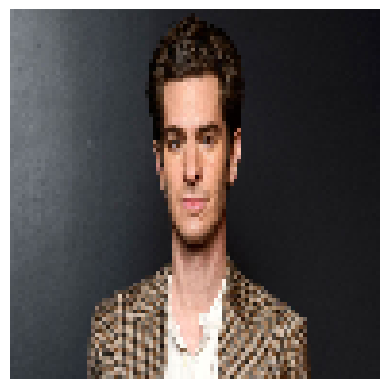

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
[[0.5033504  0.51502913 0.47818497 0.47083902 0.47176573 0.48636338
  0.48912936 0.4997819  0.50267375 0.48823148 0.48418504 0.46802527
  0.52495646 0.528737   0.5172408  0.50261724 0.51221544 0.5368946
  0.5166653  0.5013484  0.51739115 0.4498096  0.45974135 0.5408978
  0.5103315  0.50898933 0.5028465  0.4904428  0.48032254 0.48655346
  0.47228494 0.5205109  0.5347     0.4990675  0.48351124 0.52876395
  0.5218056  0.5143046  0.5165806  0.4901163  0.47906703 0.5003005
  0.5100111  0.5135793  0.44990048 0.500842   0.47662932 0.4796652
  0.4935754  0.52159953 0.50389206 0.47456565 0.5204146  0.49596557
  0.48001915 0.5281364  0.49634865 0.48107034 0.47876784 0.54021543
  0.5014895  0.48175347 0.5101921  0.49798837 0.543815   0.482882
  0.51030195 0.44706288 0.47317538 0.47995198 0.47719124 0.51634085
  0.46613088 0.5076199  0.51756257 0.5127537  0.50847256 0.5513287
  0.48831382 0.4869449  0.46177524 0.54964155 0.46921682 0.4894821
  0.4988581  0.47

In [11]:
# Step 4: Display the image
import matplotlib.pyplot as plt  # For displaying the image

plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()


# Step 5: Generate encoding
encoding = model.predict(img_array)

# Print the encoding to verify
print(encoding)

In [13]:
# Ensure you have the necessary packages installed
!pip install python-docx matplotlib scikit-learn

import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from docx import Document
from docx.shared import Inches

# Define the model (this should be replaced with your actual model)
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='sigmoid')  # Example output layer for embeddings
])

model.compile(optimizer='adam', loss='binary_crossentropy')

# Function to preprocess and encode an image
def preprocess_and_encode(img_path, model):
    img = image.load_img(img_path, target_size=(196, 196))  # Resize to the model's input size
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize the image
    return model.predict(img_array)

# Path to the new image of the same individual
new_image_path = "/content/image/Dean.jpg"  # Update with the actual image path

# Preprocess and encode the new image
new_image_encoding = preprocess_and_encode(new_image_path, model)

# Path to the database encodings (this should be replaced with your actual encodings)
database_encodings = np.array([...])  # Replace with actual database encodings

# Perform face recognition
distances = pairwise_distances(new_image_encoding, database_encodings)

# Create the output dictionary for L2 distances
output = {
    "distances": distances
}

# Create a new Document
doc = Document()
doc.add_heading('Face Recognition Results', 0)

# Add the new images to the Word document
doc.add_heading('New Images', level=1)

# Add the new image
doc.add_heading('New Image', level=2)
doc.add_picture(new_image_path, width=Inches(4))

# Add a screenshot of the face verification output
doc.add_heading('Face Verification Output', level=2)
doc.add_picture('path_to_screenshot_of_face_verification.png', width=Inches(4))

# Add a screenshot of the face recognition output
doc.add_heading('Face Recognition Output', level=2)
doc.add_picture('path_to_screenshot_of_face_recognition.png', width=Inches(4))

# Add a section for output[2] (L2 distances)
doc.add_heading('Output[2]', level=1)
doc.add_paragraph('L2 distances between the target image encoding and the database embeddings:')
doc.add_paragraph(str(output["distances"]))

# Save the document
doc.save('Face_Recognition_Results.docx')

ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_12" is incompatible with the layer: expected axis -1 of input shape to have value 70688, but received input with shape (1, 301088)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(1, 196, 196, 3), dtype=float32)
  • training=False
  • mask=None